# Time Series with Python

© Francesco Mosconi, 2016

## Classification
- generating data
- feature engineering
- rolling windows

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 11, 7
import random
np.random.seed(41)
random.seed(41)

## Motivation:
![Spinbot](./spinbot_timeseries.png)

## Generate data

- smooth curve or some sort

In [2]:
def gen_curve(l=400, repeats=1):
    x = np.linspace(0, 2*np.pi*repeats, l*repeats)
    lab = np.array([False]*l*repeats)
    coeffs = np.random.uniform(0, np.pi, size=(4,4))
    y = np.zeros(l*repeats)
    for i, c in enumerate(coeffs):
        y += c[0] + c[1]*np.sin(c[2]*x/(0.5*np.pi) + c[3])
    return y

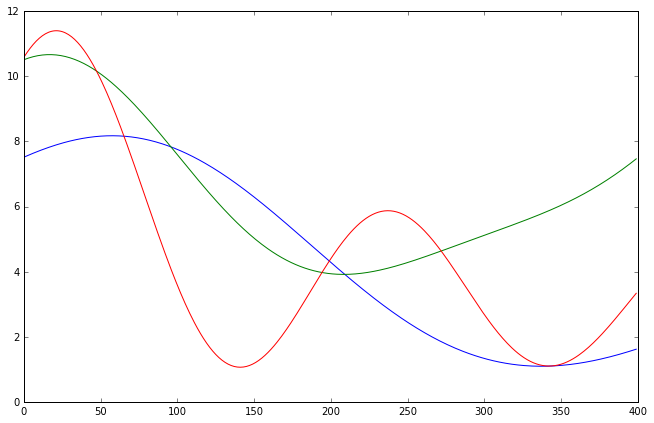

In [3]:
plt.plot(gen_curve())
plt.plot(gen_curve())
plt.plot(gen_curve())

## Generate Anomaly
- higher frequency
- localized

In [4]:
def gen_anomaly(l=400, duration=40, scale=1.0):
    start = np.random.randint(0, l-duration)
    y = np.zeros(l)
    y[start:start+duration] = np.hanning(duration)
    x = np.linspace(0, 2*np.pi, l)
    freq = np.random.uniform(300, 800)
    z = np.sin(freq*x/(2*np.pi))
    return scale*y*z

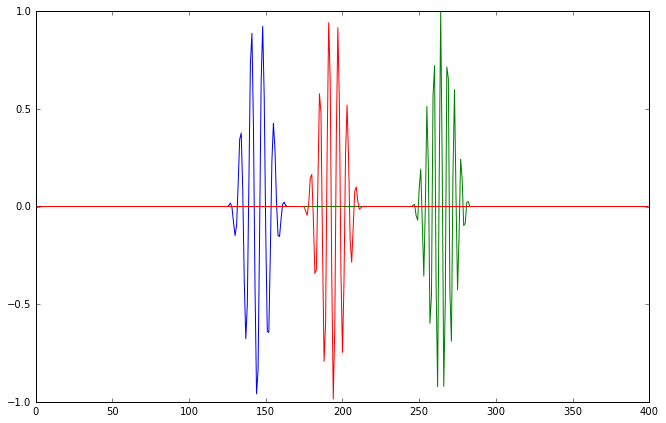

In [5]:
plt.plot(gen_anomaly())
plt.plot(gen_anomaly())
plt.plot(gen_anomaly())

## Combine the two

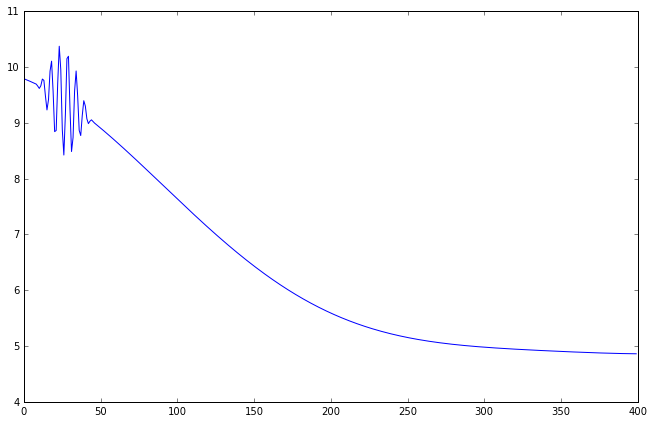

In [6]:
plt.plot(gen_curve() + gen_anomaly())

## Generate dataset
- 10000 curves
- all with the same length
- 50% with anomaly
- 50% without anomaly

In [7]:
sequences = []
y = []
for i in xrange(5000):
    y0 = gen_curve()
    y1 = gen_curve() + gen_anomaly()
    sequences.append(y0)
    sequences.append(y1)
    y.extend([False, True])

sequences = pd.DataFrame(sequences)
y = np.array(y)

In [8]:
sequences.head()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,11.431788,11.429842,11.427555,11.424928,11.421963,11.418660,11.415023,11.411051,11.406747,11.402113,...,11.719375,11.746138,11.772745,11.799191,11.825472,11.851585,11.877525,11.903288,11.928871,11.954269
1,8.872285,8.906950,8.940354,8.972467,9.003260,9.032702,9.060765,9.087422,9.112645,9.136408,...,5.148448,5.125051,5.102633,5.081197,5.060743,5.041274,5.022789,5.005288,4.988770,4.973232
2,9.364854,9.411107,9.456588,9.501259,9.545081,9.588016,9.630027,9.671077,9.711131,9.750153,...,2.732656,2.774922,2.817540,2.860469,2.903666,2.947087,2.990690,3.034431,3.078267,3.122154
3,11.051841,11.002287,10.951602,10.899823,10.846989,10.793139,10.738312,10.682550,10.625892,10.568380,...,8.434031,8.480470,8.525437,8.568913,8.610883,8.651332,8.690245,8.727611,8.763416,8.797652
4,9.433610,9.446830,9.459810,9.472545,9.485030,9.497262,9.509237,9.520951,9.532399,9.543579,...,7.432099,7.452410,7.472613,7.492703,7.512674,7.532523,7.552245,7.571836,7.591291,7.610605


## Inspect first 4 curves

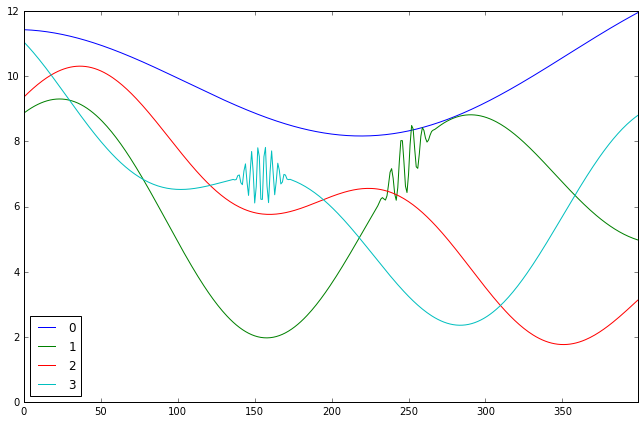

In [9]:
sequences.iloc[:4].transpose().plot()

## Question:

how do we build features to detect this particular type of anomaly?

## Start simple: rescale

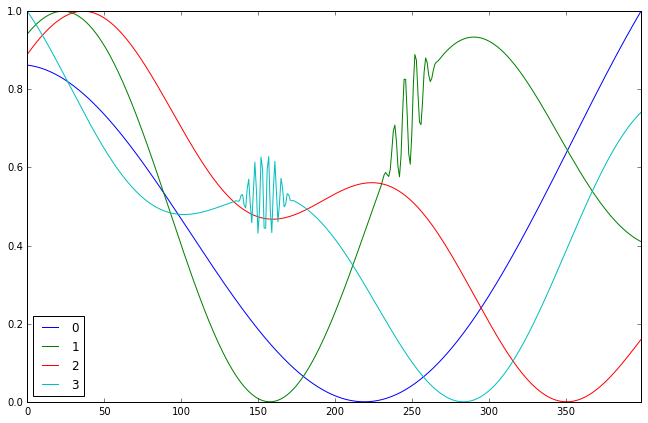

In [10]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
sequences_scaled = pd.DataFrame(mms.fit_transform(sequences.transpose()).transpose())
sequences_scaled.iloc[:4].transpose().plot()

## First idea: use standard deviation

In [11]:
X = pd.DataFrame(sequences_scaled.std(axis=1), columns = ['std'])

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score

model = LogisticRegression()
cross_val_score(model, X, y)

array([ 0.56568686,  0.55608878,  0.55522209])

=> better than random, but not so great actually

## Histogram

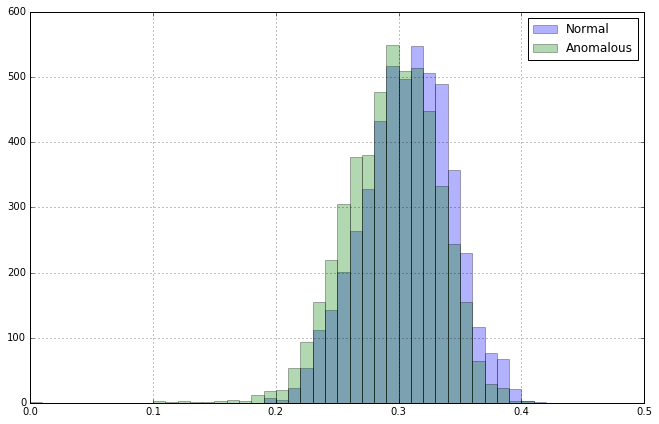

In [13]:
X[y==False]['std'].hist(bins=50, range=(0, 0.5), alpha =0.3)
X[y==True]['std'].hist(bins=50, range=(0, 0.5), alpha =0.3)
plt.legend(['Normal', 'Anomalous'])

## Next idea: standard deviation of differences

In [14]:
X['std_diff'] = sequences_scaled.diff(axis=1).std(axis=1)

In [15]:
cross_val_score(model, X, y)

array([ 0.87522496,  0.84643071,  0.87484994])

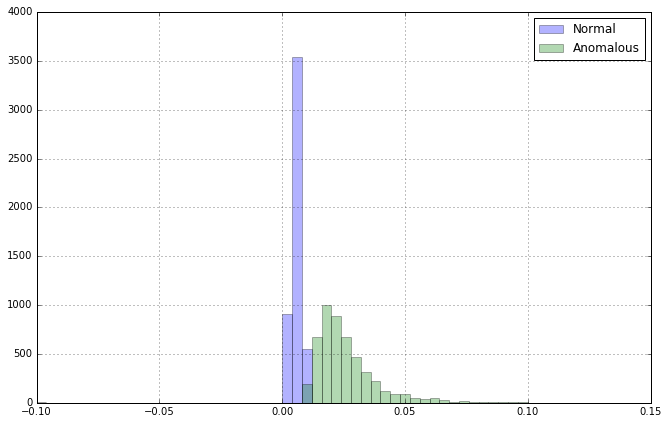

In [16]:
X[y==False]['std_diff'].hist(bins=50, range=(-0.1, 0.1), alpha =0.3)
X[y==True]['std_diff'].hist(bins=50, range=(-0.1, 0.1), alpha =0.3)
plt.legend(['Normal', 'Anomalous'])

## Next idea: use a different model

In [17]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
cross_val_score(model, X, y)

array([ 0.99220156,  0.99370126,  0.99279712])

That was easy...

## What if there's noise?

In [18]:
def gen_noise(l=400, scale=None):
    if scale is not None:
        noise = np.random.normal(scale=scale, size=l)
    else:
        noise = np.random.normal(scale=np.abs(np.random.normal(scale=0.1)), size=l)
    return noise

In [19]:
sequences = []
y = []
for i in xrange(5000):
    y0 = gen_curve() + gen_noise()
    y1 = gen_curve() + gen_anomaly() + gen_noise()
    sequences.append(y0)
    sequences.append(y1)
    y.extend([False, True])

sequences = pd.DataFrame(sequences)
y = np.array(y)

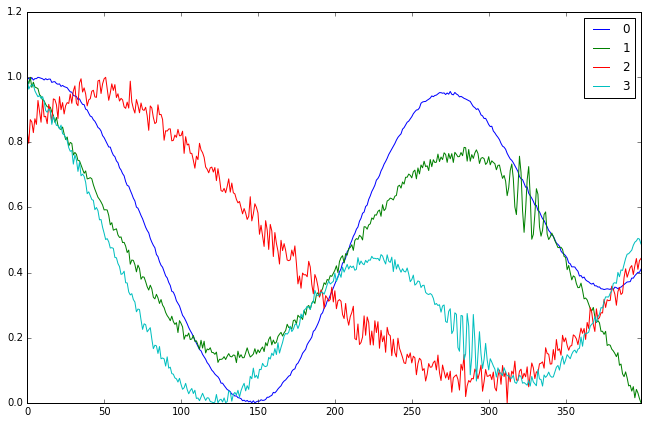

In [20]:
sequences_scaled = pd.DataFrame(mms.fit_transform(sequences.transpose()).transpose())
sequences_scaled.iloc[:4].transpose().plot()

In [21]:
X = pd.DataFrame(sequences_scaled.std(axis=1), columns = ['std'])
X['std_diff'] = sequences_scaled.diff(axis=1).std(axis=1)
cross_val_score(model, X, y)

array([ 0.64967007,  0.65626875,  0.65876351])

## Exercise:

- can you think of any other feature to add?
- try with some other models and see if you can improve the score

## Fourier features to the rescue
In this example, the anomaly has a higher frequency than the base signal. Could we isolate it based on the frequency spectrum?

In [22]:
from scipy.signal import welch
fff, Pxx = welch(sequences_scaled, nperseg=64, axis=1)
X = pd.DataFrame(Pxx)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0.015830,0.320406,0.020068,0.000855,0.000187,0.000033,0.000025,0.000015,0.000016,0.000016,...,0.000017,0.000013,0.000012,0.000014,0.000013,0.000016,0.000020,0.000015,0.000014,0.000006
1,0.004965,0.177030,0.010379,0.000610,0.000396,0.000199,0.000274,0.000188,0.000120,0.000507,...,0.000143,0.000246,0.000341,0.000242,0.000180,0.000233,0.000275,0.000251,0.000249,0.000152
2,0.002017,0.062938,0.003294,0.001812,0.001905,0.001788,0.000997,0.001867,0.001808,0.001503,...,0.000949,0.000696,0.000695,0.000736,0.001052,0.001408,0.001699,0.001468,0.001439,0.000803
3,0.010038,0.195164,0.012117,0.000759,0.000192,0.000245,0.000163,0.000187,0.000233,0.000215,...,0.000250,0.000179,0.000190,0.000253,0.000301,0.000232,0.000194,0.000170,0.000226,0.000215
4,0.013747,0.266927,0.016350,0.001008,0.000247,0.000122,0.000160,0.000101,0.000074,0.000069,...,0.000125,0.000108,0.000081,0.000074,0.000115,0.000115,0.000181,0.000189,0.000192,0.000070


## First few curves

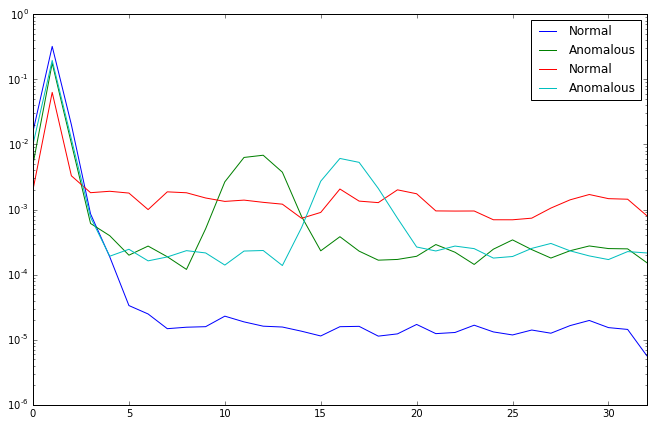

In [23]:
X.iloc[:4].transpose().plot(logy=True)
plt.legend(['Normal', 'Anomalous', 'Normal', 'Anomalous'])

In [24]:
cross_val_score(model, X, y)

array([ 0.96640672,  0.97810438,  0.97208884])

In [25]:
model.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

## Anomaly detection

Let's see if we can use the model we just trained to detect anomalies in a long sequence.

In [26]:
# generate sequence
long_series = gen_curve(l=400, repeats=250) + gen_noise(l=400*250)

# pick 20 indices at random
anom_indexes = np.array(sorted(np.random.choice(xrange(len(long_series-400)), size=20)))

# insert anomaly at each index
for i in anom_indexes:
    anomaly = gen_anomaly()
    l = len(anomaly)
    long_series[i:i+l] += anomaly


## Visualize one such anomaly...

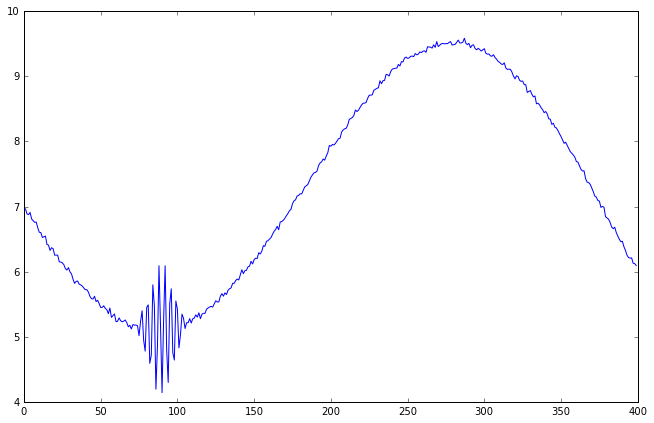

In [27]:

plt.plot(long_series[anom_indexes[0]: anom_indexes[0]+400])

## Rolling windows

- choose windows of size 400
- overlap by 200

In [28]:
def window_stack(a, stepsize=200, width=400):
    return np.vstack( a[i:1+i-width or None:stepsize] for i in range(0,width)).transpose()

wins = window_stack(long_series)

In [29]:
wins.shape

(499, 400)

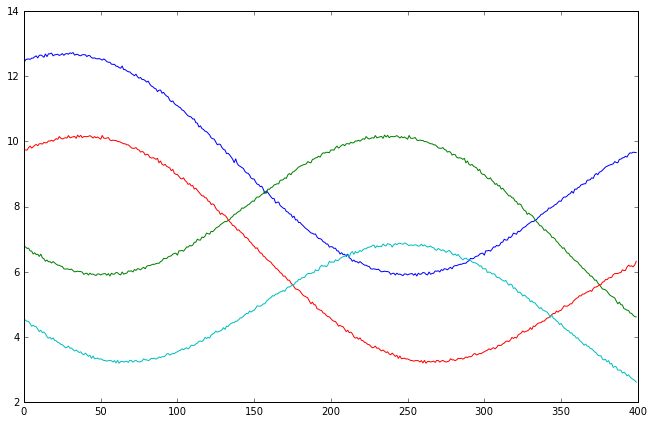

In [30]:
plt.plot(wins[:4].transpose())

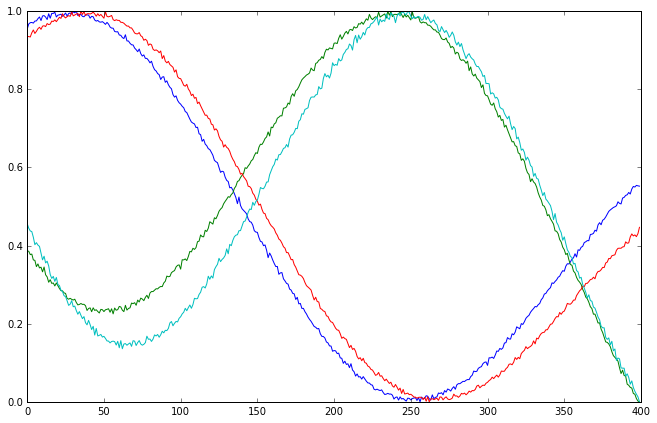

In [31]:
wins_scaled = mms.fit_transform(wins.transpose()).transpose()
plt.plot(wins_scaled[:4].transpose())

In [32]:
fff, Pxx = welch(wins_scaled, nperseg=64, axis=1)
X2 = pd.DataFrame(Pxx)
y_pred = model.predict(X2)
sum(y_pred)

38

## Did we find them?

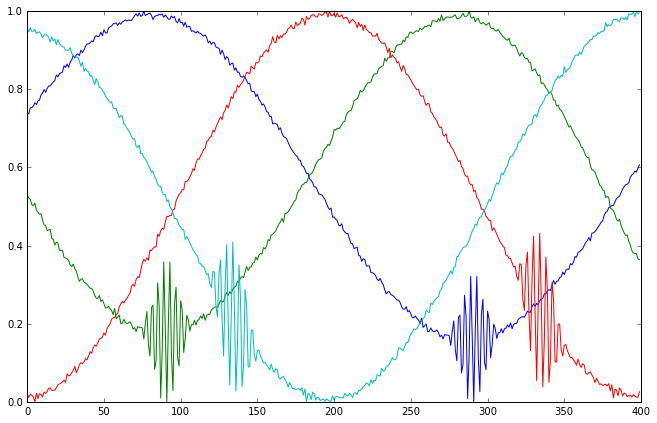

In [33]:
plt.plot(wins_scaled[y_pred == True][:4].transpose())

## Exercises:

- what if the noise is stronger? Does the fourier model still find the anomalies? or are there false positives? Try playing around with the noise `scale` parameter to see what happens.

- what if we didn't have a well balanced training set? how could we train the model using just the data from the long_series? try using KMeans clustering on the features extracted from the windows.


## Next steps:

- [Neural networks for anomaly detection](https://www.quora.com/How-do-I-use-LSTM-Networks-for-time-series-anomaly-detection)
- [Numenta & Hierarchical Temporal Memory models](http://numenta.org/)